In [1]:
# DETECTION: Convert bounding boxes to YOLO format
import os
import pandas as pd
from PIL import Image

df = pd.read_csv('Licplatesdetection_train.csv')
images_dir = 'license_plates_detection_train'
labels_dir = 'detection_labels_yolo'
os.makedirs(labels_dir, exist_ok=True)

for _, row in df.iterrows():
    img_path = os.path.join(images_dir, row['img_id'])
    label_path = os.path.join(labels_dir, row['img_id'].replace('.jpg', '.txt'))

    try:
        img = Image.open(img_path)
        w, h = img.size

        x_center = ((row['xmin'] + row['xmax']) / 2) / w
        y_center = ((row['ymin'] + row['ymax']) / 2) / h
        bbox_width = (row['xmax'] - row['xmin']) / w
        bbox_height = (row['ymax'] - row['ymin']) / h

        with open(label_path, 'w') as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
    except Exception as e:
        print(f"Error: {row['img_id']} - {e}")


In [2]:
# RECOGNITION: Save image-text pairs for OCR
df_rec = pd.read_csv('Licplatesrecognition_train.csv')
df_rec.to_csv('recognition_labels.csv', index=False, header=False)
print("Saved recognition_labels.csv")


Saved recognition_labels.csv


In [3]:
# Install YOLOv5 (Ultralytics)
!pip install -q ultralytics


In [4]:
# Import YOLO
from ultralytics import YOLO
model = YOLO('yolov5s.pt')  # Start with pretrained YOLOv5-small


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [5]:
# IMPORTANT: Create a config YAML file before training
yaml_content = """
path: dataset
train: images/train
val: images/val
nc: 1
names: ['license_plate']
"""

with open("custom.yaml", "w") as f:
    f.write(yaml_content)

print("✅ custom.yaml created. Make sure dataset is structured properly.")


✅ custom.yaml created. Make sure dataset is structured properly.


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

image_dir = "license_plates_detection_train"
label_dir = "detection_labels_yolo"

# List all image files and match them with labels
images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Prepare folders
base_path = "dataset"
for split in ['train', 'val']:
    os.makedirs(os.path.join(base_path, "images", split), exist_ok=True)
    os.makedirs(os.path.join(base_path, "labels", split), exist_ok=True)

# Move files
for split, split_imgs in zip(['train', 'val'], [train_imgs, val_imgs]):
    for img in split_imgs:
        shutil.copy(os.path.join(image_dir, img), os.path.join(base_path, "images", split, img))
        label_file = img.replace('.jpg', '.txt')
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(base_path, "labels", split, label_file))

print("✅ Dataset split and structured for YOLOv5")


✅ Dataset split and structured for YOLOv5


In [7]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU available: False
Device: CPU


In [8]:
# Train YOLOv5
model.train(data='custom.yaml', epochs=10, imgsz=416, project='yolo_license_plate', name='exp', exist_ok=True)


New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.149  Python-3.12.7 torch-2.7.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

train: Scanning C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\dataset\labels\train... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:01<00:00, 237.97it/s]

train: New cache created: C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\dataset\labels\train.cache



C:\Users\Kimidi Raju\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access  (ping: 0.10.0 ms, read: 10.32.3 MB/s, size: 118.2 KB)


val: Scanning C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\dataset\labels\val... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 210.48it/s]

val: New cache created: C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\dataset\labels\val.cache



C:\Users\Kimidi Raju\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to yolo_license_plate\exp\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to yolo_license_plate\exp
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


C:\Users\Kimidi Raju\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.617       3.38      1.266         16        416: 100%|██████████| 15/15 [04:24<00:00, 17.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.02s/it]

                   all         60         60      0.701      0.867      0.884      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.231      1.215      0.997         16        416: 100%|██████████| 15/15 [18:33<00:00, 74.23s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.33s/it]

                   all         60         60      0.525      0.867      0.626      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.253      1.122      1.019         16        416: 100%|██████████| 15/15 [04:16<00:00, 17.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.22s/it]

                   all         60         60      0.582        0.7      0.639      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.322          1      1.088         16        416: 100%|██████████| 15/15 [04:30<00:00, 18.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.54s/it]

                   all         60         60      0.784      0.849      0.831      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.277     0.9128      1.045         16        416: 100%|██████████| 15/15 [04:13<00:00, 16.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.19s/it]

                   all         60         60      0.798      0.854      0.907      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G       1.26     0.8986      1.082         16        416: 100%|██████████| 15/15 [03:06<00:00, 12.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.68s/it]

                   all         60         60      0.774      0.859      0.849      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.274     0.8674      1.069         16        416: 100%|██████████| 15/15 [01:31<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.36s/it]

                   all         60         60       0.98      0.819      0.932      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.161     0.8024      1.035         16        416: 100%|██████████| 15/15 [02:11<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.11s/it]

                   all         60         60      0.965      0.906      0.962      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.127     0.7406      1.031         16        416: 100%|██████████| 15/15 [02:07<00:00,  8.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.94s/it]

                   all         60         60      0.978       0.95      0.982      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.099     0.7269      1.012         16        416: 100%|██████████| 15/15 [02:02<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  5.00s/it]

                   all         60         60      0.988      0.933      0.988      0.655



10 epochs completed in 0.830 hours.
Optimizer stripped from yolo_license_plate\exp\weights\last.pt, 18.5MB
Optimizer stripped from yolo_license_plate\exp\weights\best.pt, 18.5MB

Validating yolo_license_plate\exp\weights\best.pt...
Ultralytics 8.3.149  Python-3.12.7 torch-2.7.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


                   all         60         60      0.988      0.933      0.988      0.655
Speed: 1.8ms preprocess, 113.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to yolo_license_plate\exp


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C6A38ED8E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

# Predict using trained model on test images
model = YOLO('yolo_license_plate/exp/weights/best.pt')
results = model.predict(source='test/', save=True)


In [9]:
# Predict using trained model on test images
model = YOLO('yolo_license_plate/exp/weights/best.pt')
results = model.predict(source='test/', save=True)



image 1/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1000.jpg: 288x416 2 license_plates, 154.2ms
image 2/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1001.jpg: 416x256 1 license_plate, 216.7ms
image 3/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1002.jpg: 416x320 1 license_plate, 237.1ms
image 4/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1003.jpg: 256x416 1 license_plate, 237.0ms
image 5/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1004.jpg: 416x256 1 license_plate, 142.1ms
image 6/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1005.jpg: 416x256 1 license_plate, 154.1ms
image 7/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1006.jpg: 416x320 1 license_plate, 129.5ms
image 8/210 C:\Users\Kimidi Raju\ASA.0feeafb8-9061-466f-a0ea-f8651f35c51d\test\1007.jpg: 416x256 1 license_plate, 109.4ms
image 9/210 C:\Users\K

In [10]:
# Install EasyOCR
!pip install -q easyocr

In [11]:
import easyocr
import pandas as pd
import os
from PIL import Image
from IPython.display import display

reader = easyocr.Reader(['en'])
df = pd.read_csv('recognition_labels.csv', header=None, names=['img', 'label'])
img_dir = 'license_plates_recognition_train'


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


C:\Users\Kimidi Raju\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


GT: 128T8086 | Pred: ['1128 >; 8086 |']


GT: 170T6123 | Pred: ['170', '3;', '6123']


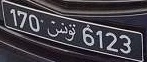

GT: 103T1643 | Pred: ['103 651643']


GT: 62T1040 | Pred: ['62 3y 1OLO']


GT: 140T1714 | Pred: ['140601714']


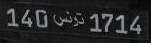

In [12]:
import cv2
from PIL import Image
from IPython.display import display

for idx, row in df.head(5).iterrows():
    img_path = os.path.join(img_dir, row['img'])

    # Convert image to grayscale using OpenCV
    img_bgr = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Pass grayscale image to easyocr
    prediction = reader.readtext(img_gray, detail=0)
    
    print(f"GT: {row['label']} | Pred: {prediction}")
    display(Image.open(img_path))


In [13]:
import os
import cv2
import pandas as pd
import easyocr

# Initialize
df = pd.read_csv('Licplatesrecognition_train.csv')
img_dir = 'license_plates_recognition_train'
reader = easyocr.Reader(['en'], gpu=False)
results = []

# Iterate and read text
for idx, row in df.iterrows():
    img_path = os.path.join(img_dir, row['img_id'])

    # Read and convert to grayscale
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Image not found or unreadable: {img_path}")
        continue

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # OCR prediction
    result = reader.readtext(img_gray, detail=0)
    results.append({'img': row['img_id'], 'gt': row['text'], 'predicted': ' '.join(result)})

# Save results
pd.DataFrame(results).to_csv('ocr_predictions.csv', index=False)


Using CPU. Note: This module is much faster with a GPU.
C:\Users\Kimidi Raju\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [14]:
import pandas as pd

df = pd.read_csv('ocr_predictions.csv')
print(df.head(20))  # View first 10 results to spot-check


       img        gt       predicted
0    1.jpg  128T8086  1128 >; 8086 |
1    2.jpg  170T6123     170 3; 6123
2    3.jpg  103T1643      103 651643
3    4.jpg   62T1040      62 3y 1OLO
4    5.jpg  140T1714       140601714
5    6.jpg  121T4099     [1213454099
6    7.jpg  160T7750    [60 27 7750]
7    8.jpg   39T5898   39 323 5898 _
8    9.jpg  157T6832      1578 96832
9   10.jpg   94T3458      '9L693158|
10  11.jpg   96T8557     096 8557 35
11  12.jpg  156T2325     1563*5 2325
12  13.jpg  182T2759       [82632759
13  14.jpg   85T3827     85 8 i 3827
14  16.jpg  159T3782     [159* 53782
15  17.jpg  195T2612     195*-92612]
16  18.jpg  153T3222      1538753222
17  19.jpg   43T9644        L35,6944
18  20.jpg   64T6581         6~36581
19  21.jpg  117T6491        M7856491


In [15]:
import pandas as pd

def char_accuracy(gt, pred):
    matches = sum(1 for a, b in zip(gt, pred) if a == b)
    max_len = max(len(gt), len(pred))
    if max_len == 0:
        return 1.0
    return matches / max_len

df = pd.read_csv('ocr_predictions.csv')

# Convert to strings to avoid TypeError
df['gt'] = df['gt'].astype(str)
df['predicted'] = df['predicted'].astype(str)

df['correct'] = df['gt'] == df['predicted']
exact_match_acc = df['correct'].mean()
print(f"Exact match accuracy: {exact_match_acc:.2%}")

df['char_acc'] = df.apply(lambda row: char_accuracy(row['gt'], row['predicted']), axis=1)
avg_char_acc = df['char_acc'].mean()
print(f"Average character-level accuracy: {avg_char_acc:.2%}")

errors = df[df['correct'] == False]
print(f"\nNumber of errors: {len(errors)}")
print("\nSome examples of OCR errors:")
display(errors[['img', 'gt', 'predicted']].head(10))


Exact match accuracy: 0.00%
Average character-level accuracy: 22.09%

Number of errors: 298

Some examples of OCR errors:


,img,gt,predicted
0,1.jpg,128T8086,1128 >; 8086 |
1,2.jpg,170T6123,170 3; 6123
2,3.jpg,103T1643,103 651643
3,4.jpg,62T1040,62 3y 1OLO
4,5.jpg,140T1714,140601714
5,6.jpg,121T4099,[1213454099
6,7.jpg,160T7750,[60 27 7750]
7,8.jpg,39T5898,39 323 5898 _
8,9.jpg,157T6832,1578 96832
9,10.jpg,94T3458,'9L693158|


In [16]:
%matplotlib inline


Exact match accuracy: 0.00%
Average character-level accuracy: 22.09%

Number of errors: 298


,img,gt,predicted
0,1.jpg,128T8086,1128 >; 8086 |
1,2.jpg,170T6123,170 3; 6123
2,3.jpg,103T1643,103 651643
3,4.jpg,62T1040,62 3y 1OLO
4,5.jpg,140T1714,140601714
5,6.jpg,121T4099,[1213454099
6,7.jpg,160T7750,[60 27 7750]
7,8.jpg,39T5898,39 323 5898 _
8,9.jpg,157T6832,1578 96832
9,10.jpg,94T3458,'9L693158|


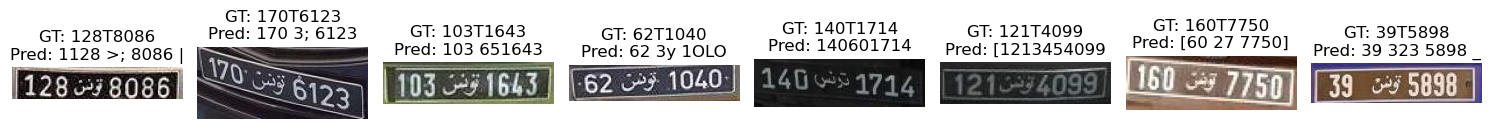

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

def char_accuracy(gt, pred):
    matches = sum(1 for a, b in zip(gt, pred) if a == b)
    max_len = max(len(gt), len(pred))
    if max_len == 0:
        return 1.0
    return matches / max_len

# Load OCR results
df = pd.read_csv('ocr_predictions.csv')

# Convert columns to string
df['gt'] = df['gt'].astype(str)
df['predicted'] = df['predicted'].astype(str)

# Calculate accuracies
df['correct'] = df['gt'] == df['predicted']
exact_match_acc = df['correct'].mean()
df['char_acc'] = df.apply(lambda row: char_accuracy(row['gt'], row['predicted']), axis=1)
avg_char_acc = df['char_acc'].mean()

print(f"Exact match accuracy: {exact_match_acc:.2%}")
print(f"Average character-level accuracy: {avg_char_acc:.2%}")

# Show a table of first 10 errors
errors = df[df['correct'] == False]
print(f"\nNumber of errors: {len(errors)}")
display(errors[['img', 'gt', 'predicted']].head(15))

# Parameters: set your image directory here
img_dir = 'license_plates_recognition_train'  # change if needed

# Show images for first 5 errors
num_images_to_show = 8
plt.figure(figsize=(15, 6))

for i, (_, row) in enumerate(errors.head(num_images_to_show).iterrows()):
    img_path = os.path.join(img_dir, row['img'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"GT: {row['gt']}\nPred: {row['predicted']}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Exact match accuracy: 0.00%
Average character-level accuracy: 22.09%

Number of errors: 298


,img,gt,predicted
0,1.jpg,128T8086,1128 >; 8086 |
1,2.jpg,170T6123,170 3; 6123
2,3.jpg,103T1643,103 651643
3,4.jpg,62T1040,62 3y 1OLO
4,5.jpg,140T1714,140601714
5,6.jpg,121T4099,[1213454099
6,7.jpg,160T7750,[60 27 7750]
7,8.jpg,39T5898,39 323 5898 _
8,9.jpg,157T6832,1578 96832
9,10.jpg,94T3458,'9L693158|


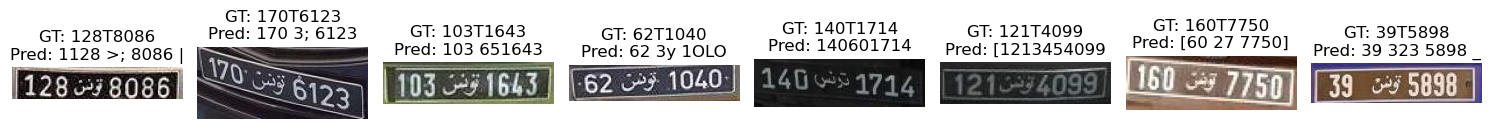

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

def char_accuracy(gt, pred):
    matches = sum(1 for a, b in zip(gt, pred) if a == b)
    max_len = max(len(gt), len(pred))
    if max_len == 0:
        return 1.0
    return matches / max_len

# Load OCR results
df = pd.read_csv('ocr_predictions.csv')

# Convert columns to string
df['gt'] = df['gt'].astype(str)
df['predicted'] = df['predicted'].astype(str)

# Calculate exact match accuracy and average character-level accuracy
df['correct'] = df['gt'] == df['predicted']
exact_match_acc = df['correct'].mean()
df['char_acc'] = df.apply(lambda row: char_accuracy(row['gt'], row['predicted']), axis=1)
avg_char_acc = df['char_acc'].mean()

print(f"Exact match accuracy: {exact_match_acc:.2%}")
print(f"Average character-level accuracy: {avg_char_acc:.2%}")

# Show first 15 error examples in tabular form
errors = df[df['correct'] == False]
print(f"\nNumber of errors: {len(errors)}")
display(errors[['img', 'gt', 'predicted']].head(15))

# Visualization Parameters
img_dir = 'license_plates_recognition_train'  # Change if needed
num_images_to_show = 8

plt.figure(figsize=(15, 6))

for i, (_, row) in enumerate(errors.head(num_images_to_show).iterrows()):
    img_path = os.path.join(img_dir, row['img'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"GT: {row['gt']}\nPred: {row['predicted']}")
    plt.axis('off')

plt.tight_layout()
plt.show()
